State Management and Persistence in LangGraph
State in LangGraph acts as a data package that flows through nodes, carrying relevant information within a single execution. However, state does not persist between invocations, meaning each new execution starts from scratch.

State Limitations
When a workflow runs, it processes state only for that instance. Once execution finishes, the state is discarded. If re-invoked, the previous state is lost, which breaks continuity for applications like chatbots that need memory.

Adding Short-Term Memory with Checkpoints
To persist state across multiple runs, checkpoints store snapshots of state at each step. LangGraph provides MemorySaver(), an in-memory checkpoint system, to retain state temporarily.

from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
Using Threads for Persistent State
Checkpoints are organized into threads, similar to conversation histories in ChatGPT. Each execution must include a thread ID to retrieve past interactions.

config = {"configurable": {"thread_id": "1"}}
graph.invoke({"node_name": ""}, config)
If the same thread ID is used again, the state continues from where it left off.

# Output:
# {'node_name': 'b', 'value': ['a', 'b', 'a', 'b']}
Accessing State History
LangGraph allows retrieval of state history for debugging and analysis.

list(graph.get_state_history(config))
Returns a chronological list of state snapshots, showing how the workflow evolved.

Final Thoughts
State is ephemeral—without checkpoints, it resets after each execution.
MemorySaver() is useful for debugging, but production systems should use PostgresSaver() for reliability.
Threads track execution history, enabling persistent AI-driven interactions.
By combining state tracking, checkpoints, and threads, LangGraph enables intelligent, memory-aware applications that evolve dynamically.

L3_demo_08_checkpoints

In [1]:
from typing import TypedDict, List, Annotated
import operator
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from IPython.display import Image, display

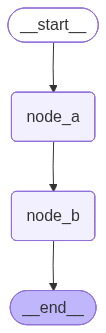

In [2]:
class State(TypedDict):
    value: Annotated[List[str], operator.add]

def node_a(state: State):
    return {"value": ["a"]}

def node_b(state: State):
    return {"value": ["b"]}

workflow = StateGraph(State)

workflow.add_node(node_a)
workflow.add_node(node_b)

workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [4]:
graph.invoke({"value":[]})

{'value': ['a', 'b']}

Checkpoints

In [ ]:
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

In [ ]:
config = {"configurable": {"thread_id": "1"}}
graph.invoke({"value": []}, config)

In [ ]:
config = {"configurable": {"thread_id": "1"}}
graph.invoke({"value": []}, config)

In [ ]:
config = {"configurable": {"thread_id": "2"}}
graph.invoke({"value": []}, config)

In [ ]:
config = {"configurable": {"thread_id": "3"}}
graph.invoke({"value": []}, config)

In [ ]:
list(graph.get_state_history({"configurable": {"thread_id": "1"}}))

In [ ]:
list(graph.get_state_history({"configurable": {"thread_id": "2"}}))

## Summary: Threads and Checkpoints in LangGraph
Overview
This demo explains how to use threads and checkpoints in LangGraph workflows. These features enable persistent conversation tracking and state snapshotting, which are critical for building multi-turn, stateful workflows and agents.

Key Steps Covered  
1. Basic Workflow Setup  
a. State Definition
A State is defined with a value field as a list of strings.
A reducer (operator.add) is applied to value, allowing safe merging of updates from different nodes.
class State(TypedDict):
  value: List[str]
b. Node Definitions
node_a: Appends "a" to the value list.
node_b: Appends "b" to the value list.
def node_a(state):
  return {"value": ["a"]}

def node_b(state):
  return {"value": ["b"]}
c. Workflow Construction
Nodes: node_a and node_b.
Edges:
start → node_a → node_b → end
workflow.add_node("node_a", node_a)
workflow.add_node("node_b", node_b)
workflow.add_edge("start", "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", "end")
d. Basic Execution
Invoking the workflow with an empty list as input produces:
["a", "b"]
Re-running without any checkpointing does not retain any additional memory or history.  
2. Adding Checkpoints  
a. Memory Checkpointer Setup
A MemorySaver checkpointer is created.
When building the workflow, the checkpointer is passed into the graph.
from langgraph.checkpoints import MemorySaver

checkpointer = MemorySaver()
workflow = StateGraph(State, checkpointer=checkpointer)
b. Using Config and Thread IDs
Each invocation now accepts a RunnableConfig with a thread_id specified.
Same thread_id → state snapshots accumulate.
Different thread_id → separate histories.
workflow.invoke({"value": []}, config={"thread_id": "1"})
c. Behavior Differences
Without checkpointing: Every run is stateless.
With checkpointing:
Running twice with thread_id="1" appends twice → ["a", "b", "a", "b"]
New thread_id values (e.g., "2", "3") start fresh each time.  
3. Viewing State History  
The state history for a thread can be retrieved using:
workflow.get_state_history(thread_id="1")
State snapshots include:

Node transitions (e.g., from start to node_a to node_b to end).
The evolving value list at each step.
Example:

After two invocations under thread ID "1":
First run: ["a", "b"]
Second run: ["a", "b", "a", "b"]
Thread ID "2" or "3" will show only one cycle of ["a", "b"].
  
4. Key Concepts Highlighted  
Threads allow partitioning workflow runs by conversation ID or user session.
Checkpoints automatically snapshot state after each node.
State history retrieval enables:
Debugging workflows
Resuming from intermediate steps
Auditing or replaying execution  
5. Conclusion  
Threads and checkpoints are foundational for building persistent, multi-turn, and recoverable workflows.
LangGraph’s checkpointer mechanism enables lightweight memory without needing external databases.
This system is scalable to more complex workflows involving LLMs, agents, and external data integrations.